# Faza 1

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import shapiro
from sklearn.preprocessing import LabelEncoder

## 1.1 A

Reading dataframe, separator is tab

In [136]:
conn_df = pd.read_csv("connections.csv", sep="\t")
proc_df = pd.read_csv("processes.csv", sep="\t")
devices_df = pd.read_csv("devices.csv", sep="\t")
profiles_df = pd.read_csv("profiles.csv", sep="\t")

### Size each dataframe

In [105]:
print("Connections size (rows, columns):", conn_df.shape)
print("Processes size (rows, columns):", proc_df.shape)
print("Devices size (rows, columns):", devices_df.shape)
print("Profiles size (rows, columns):", profiles_df.shape)

Connections size (rows, columns): (15143, 13)
Processes size (rows, columns): (15143, 23)
Devices size (rows, columns): (2963, 6)
Profiles size (rows, columns): (2537, 12)


### Types of attributes

In [106]:
conn_df.dtypes

ts                    object
imei                   int64
mwra                 float64
c.dogalize           float64
c.android.chrome     float64
c.katana             float64
c.android.youtube    float64
c.android.gm         float64
c.updateassist       float64
c.android.vending    float64
c.UCMobile.intl      float64
c.UCMobile.x86       float64
c.raider             float64
dtype: object

Types are imported correctly

In [107]:
proc_df.dtypes

ts                             object
imei                            int64
mwra                          float64
p.android.packageinstaller    float64
p.android.documentsui         float64
p.android.chrome              float64
p.android.settings            float64
p.android.externalstorage     float64
p.android.gm                  float64
p.system                      float64
p.browser.provider            float64
p.notifier                    float64
p.simulator                   float64
p.gms.persistent              float64
p.katana                      float64
p.android.defcontainer        float64
p.process.gapps               float64
p.olauncher                   float64
p.dogalize                    float64
p.android.vending             float64
p.google                      float64
p.inputmethod.latin           float64
p.android.gms                 float64
dtype: object

Types are imported correctly

In [108]:
devices_df.dtypes

latitude      float64
longitude     float64
store_name     object
code           object
location       object
imei            int64
dtype: object

Types are imported correctly

In [109]:
profiles_df.dtypes

registration        object
username            object
residence           object
company             object
name                object
birthdate           object
ssn                 object
mail                object
user_id              int64
current_location    object
imei                 int64
job                 object
dtype: object

Types are imported correctly

There is no sign of mistype in any of these dataframes

In [110]:
print("Connections attributes:", *conn_df.columns)
print("Processes attributes:", *proc_df.columns)
print("Devices attributes:", *devices_df.columns)
print("Profiles attributes:", *profiles_df.columns)


Connections attributes: ts imei mwra c.dogalize c.android.chrome c.katana c.android.youtube c.android.gm c.updateassist c.android.vending c.UCMobile.intl c.UCMobile.x86 c.raider
Processes attributes: ts imei mwra p.android.packageinstaller p.android.documentsui p.android.chrome p.android.settings p.android.externalstorage p.android.gm p.system p.browser.provider p.notifier p.simulator p.gms.persistent p.katana p.android.defcontainer p.process.gapps p.olauncher p.dogalize p.android.vending p.google p.inputmethod.latin p.android.gms
Devices attributes: latitude longitude store_name code location imei
Profiles attributes: registration username residence company name birthdate ssn mail user_id current_location imei job


We can notice, that all dataframes have *imei* attribute in it. IMEI stands for _International Mobile Equipment Identity_. So each row just represent particular data about single android device.

We can also notice, that connections and procecesses have the same naumber of rows and both have attribute called ts which stands for timestamp. It suggests that it might be logging of both connections and processes at the particular point in time:

In [111]:
(conn_df["ts"] == proc_df["ts"]).sum()

15143

In [112]:
(conn_df["imei"] == proc_df["imei"]).sum()

15143

In [113]:
(conn_df["mwra"] == proc_df["mwra"]).sum()

15143

As we can see, the IMEI and TS are equal for each record in these two datasets which proves suggestion.

The devices dataframe may give an insight in the source of the devices (i.e. the place and time of purchase). The profiles dataframe may provide us an information of the users of the devices.

However, there is not much attributes to link connections or processes with devcies or profiles except IMEI field.

In [114]:
devices_df["imei"].unique().shape

(498,)

In [115]:
devices_df["imei"].shape

(2963,)

In [116]:
profiles_df["imei"].unique().shape

(495,)

In [117]:
profiles_df["imei"].shape

(2537,)

We can see that both profiles and devices have only around 500 unique IMEI records out of \~2500/\~3000 total records. So, most probably, these record just represent data related to particular phone.

## 1.1B

Main numeric values are in processes and connections dataframes, so we will analyze attributes from these two dataframes.

Let's see distributions for all processes in processes_df:

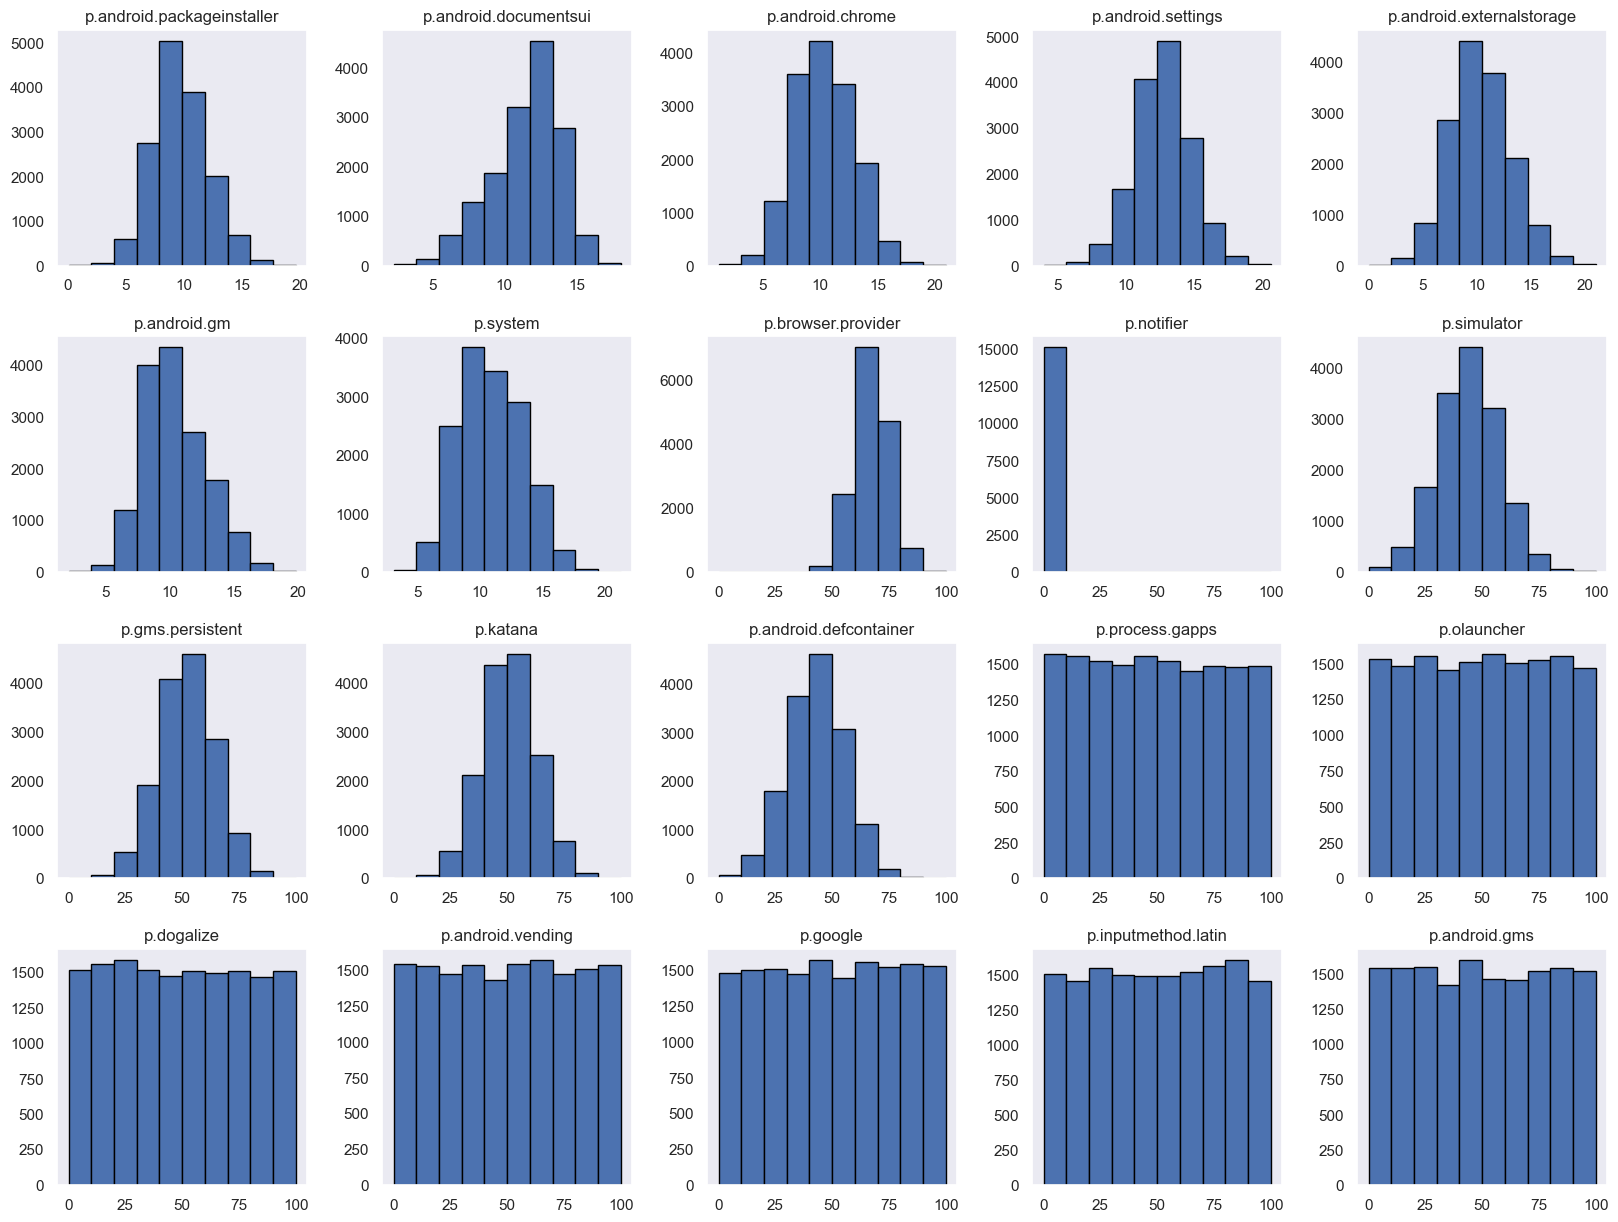

In [118]:
proc_attributes =  proc_df.select_dtypes("float")
proc_attrs = proc_attributes.loc[:, proc_attributes.columns != 'mwra']
fig, axis = plt.subplots(4, 5, figsize=(20,15))
proc_attrs.hist(ax=axis, edgecolor='black', grid=False)
plt.show()

We can also get the list of normally distributed attributes using Shapiro-Wilk test:

In [119]:
proc_norm_list = []
proc_not_norm_list = []
for column in proc_attrs:
    if shapiro(proc_attrs[column]).pvalue > 0.05:
        proc_norm_list.append(column)
    else:
        proc_not_norm_list.append(column)
print("Normally distributed processes:", proc_norm_list)

Normally distributed processes: ['p.simulator', 'p.gms.persistent', 'p.katana', 'p.android.defcontainer']


C:\Users\nidob\AppData\Local\Programs\Python\Python311\Lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 15143.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk revealed which attributes normally distributed and which attributes aren't:

In [120]:
proc_norm = proc_attrs[proc_norm_list]
proc_notnorm = proc_attrs[proc_not_norm_list]
proc_norm

,p.simulator,p.gms.persistent,p.katana,p.android.defcontainer
0,35.71788,51.77164,40.23305,41.76549
1,29.55507,46.06186,66.35247,53.31959
2,32.34265,54.17242,46.94977,39.23991
3,63.09837,67.07612,49.81393,38.59364
4,42.41401,58.73573,50.35359,65.09269
...,...,...,...,...
15138,31.43787,68.53845,44.58185,43.78864
15139,42.81895,36.46882,39.13095,38.62800
15140,44.83145,65.44567,60.74023,33.61657
15141,47.39006,28.86566,49.14036,59.81838


Let's see the descriptive statistics for the attributes:

In [121]:
proc_attrs.describe()

,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,p.browser.provider,p.notifier,p.simulator,p.gms.persistent,p.katana,p.android.defcontainer,p.process.gapps,p.olauncher,p.dogalize,p.android.vending,p.google,p.inputmethod.latin,p.android.gms
count,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000
mean,9.734081,11.530321,10.354774,12.701517,10.285296,10.386558,10.892521,67.266917,0.180368,44.079895,51.967771,50.942925,42.902683,49.438710,50.007092,49.688617,50.022847,50.306934,50.250174,49.866868
std,2.353793,2.379354,2.560366,2.043104,2.789514,2.421371,2.553577,7.803221,1.708792,13.527190,12.468146,12.141770,12.657218,28.929395,28.845051,28.905844,28.934729,28.828845,28.813387,28.957585
min,0.107530,2.332460,1.157840,4.014640,0.000000,2.147780,3.127180,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,8.108805,10.096745,8.508865,11.406915,8.352360,8.629830,8.959910,62.003040,0.001250,34.903330,43.637225,42.925860,34.388385,24.499375,24.976120,24.443920,24.924490,25.287315,25.572440,24.546590
50%,9.568570,11.921050,10.227180,12.707480,10.138900,10.030590,10.715680,67.277050,0.008600,44.087750,52.027850,50.908870,42.946220,49.204370,50.321980,49.587050,50.386190,50.211930,50.450770,49.557470
75%,11.209280,13.238575,12.194415,14.029885,12.103005,11.982615,12.780965,72.435125,0.049075,53.216140,60.404405,59.073945,51.431855,74.628445,74.997115,74.786680,74.904195,75.321355,75.259580,75.016335
max,19.659630,18.067980,20.966080,20.586340,20.975710,19.808420,21.229940,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000


Let's see distributions for all connections in conn_df:

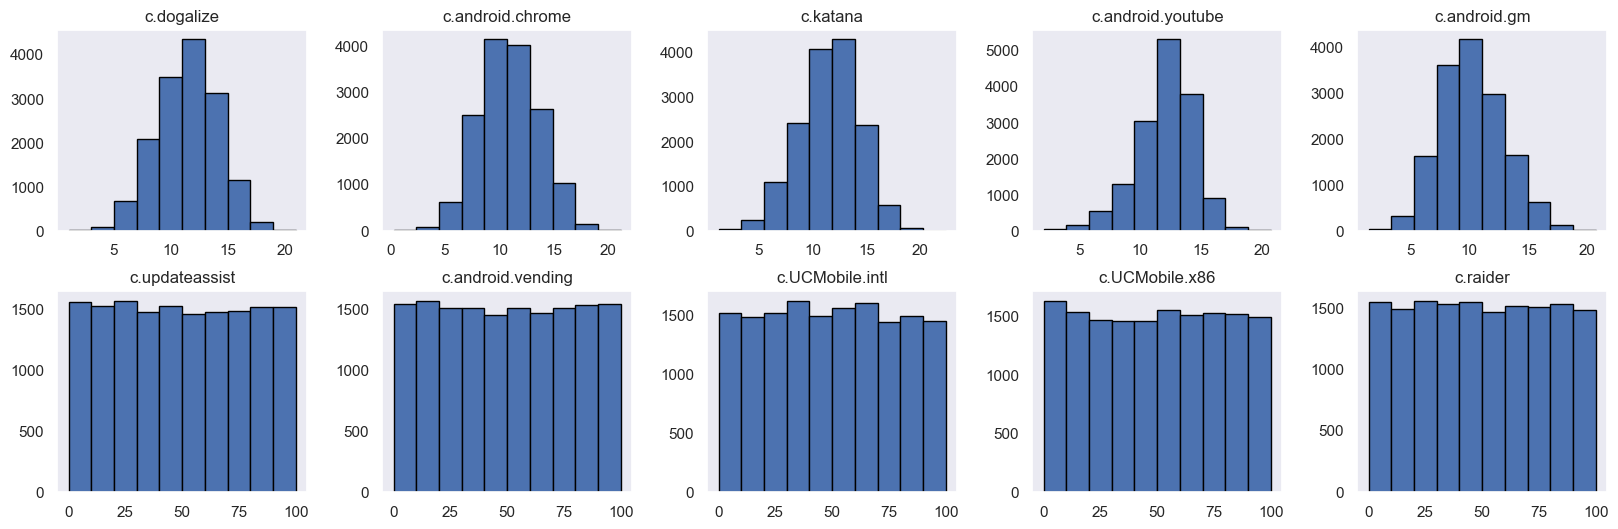

In [122]:
conn_attributes =  conn_df.select_dtypes("float")
conn_attrs = conn_attributes.loc[:, conn_attributes.columns != 'mwra']
fig, axis = plt.subplots(2, 5, figsize=(20,6))
conn_attrs.hist(ax=axis, edgecolor='black', grid=False)
plt.show()

Histograms revealed that attributes before c.updateassist are normally distributed, while the others aren't:

In [123]:
conn_norm = conn_attrs.loc[:, :"c.android.gm"]
conn_notnorm = conn_attrs.loc[:, "c.updateassist":]
conn_notnorm

,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
0,40.06991,39.05778,18.98343,71.44379,25.30727
1,96.66128,29.37613,5.72059,1.58695,93.97586
2,69.44777,78.92569,36.56047,19.09821,13.74044
3,73.38944,1.86082,71.05049,30.04595,17.95979
4,58.35019,76.91941,40.13552,39.93518,54.04827
...,...,...,...,...,...
15138,33.90189,37.20471,85.92455,15.55486,36.12666
15139,40.07666,30.93520,75.58962,88.90832,17.03351
15140,93.91890,62.94537,11.73332,91.45692,38.21706
15141,44.01314,39.58966,68.42259,73.99439,79.98017


Let's see the descriptive statistics for the attributes:

In [124]:
conn_attrs.describe()

,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
count,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000,15143.000000
mean,11.452411,10.900475,11.534564,12.061295,10.253361,49.690945,49.875202,49.711246,49.648245,49.770309
std,2.661398,2.703876,2.785804,2.325038,2.687359,28.980529,29.008906,28.682976,29.062244,28.850271
min,1.026250,0.291220,1.260930,2.053830,1.482300,0.000000,0.000000,0.000000,0.000000,0.000000
25%,9.571635,8.944125,9.717075,10.798585,8.360420,24.689315,24.641910,25.329615,24.236540,24.686350
50%,11.564450,10.834810,11.685900,12.323720,10.064370,49.265910,49.907250,49.800630,50.150860,49.457960
75%,13.314445,12.804725,13.526230,13.606590,12.044015,74.881965,75.355220,74.043395,74.871090,74.819100
max,20.936100,21.131390,22.379300,20.731990,20.710370,100.000000,100.000000,100.000000,100.000000,100.000000


Let's concatenate connections and processes into a single dataframe:

In [125]:
numeric_attrs = pd.concat([proc_attrs, conn_attrs], axis=1)
numeric_attrs

,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,p.browser.provider,p.notifier,p.simulator,...,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
0,8.91995,11.89842,8.46244,11.14348,14.47905,8.41508,10.36537,65.46982,0.01284,35.71788,...,11.97002,15.25610,10.99463,12.94905,9.87441,40.06991,39.05778,18.98343,71.44379,25.30727
1,10.68732,11.59558,11.76198,12.51138,10.27763,14.93886,8.64163,73.15339,0.00082,29.55507,...,9.06416,8.26843,12.37275,12.62434,11.03110,96.66128,29.37613,5.72059,1.58695,93.97586
2,12.18501,12.21622,14.41556,14.15739,10.33481,10.68808,9.57202,68.51992,0.00378,32.34265,...,10.71737,10.70129,11.52100,12.78995,8.83190,69.44777,78.92569,36.56047,19.09821,13.74044
3,11.99975,11.10215,14.74228,13.20422,6.66961,11.16616,11.70976,69.41012,0.00725,63.09837,...,11.38573,10.28395,14.22024,12.20206,10.84051,73.38944,1.86082,71.05049,30.04595,17.95979
4,9.37085,11.45016,6.69994,12.80673,11.81094,10.15303,9.28381,57.32590,0.00087,42.41401,...,9.08043,14.14611,9.68923,13.12646,8.82400,58.35019,76.91941,40.13552,39.93518,54.04827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15138,7.84630,9.24068,7.71016,10.24473,10.77534,10.00552,12.29869,65.77796,0.04257,31.43787,...,13.17188,9.06209,9.73345,13.07588,13.36728,33.90189,37.20471,85.92455,15.55486,36.12666
15139,9.19186,10.95426,9.49733,13.91152,8.90165,11.81112,13.24911,70.88634,0.00023,42.81895,...,7.28806,10.61374,9.49010,9.77496,9.66189,40.07666,30.93520,75.58962,88.90832,17.03351
15140,10.27414,11.35433,14.47058,10.28513,13.48562,15.08473,13.10745,68.88885,0.00018,44.83145,...,7.35113,10.57486,18.32629,13.34462,9.25235,93.91890,62.94537,11.73332,91.45692,38.21706
15141,8.58038,14.50347,12.71542,12.19887,9.23179,11.25026,15.25759,69.60882,0.00430,47.39006,...,10.86261,16.25512,10.77980,5.68572,10.28164,44.01314,39.58966,68.42259,73.99439,79.98017


Since connections and proccess share same ts, imei and mwra, let's add them too:

In [126]:
numeric_attrs = pd.concat([proc_df[["ts", "imei", "mwra"]], numeric_attrs], axis=1)
numeric_attrs

,ts,imei,mwra,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,...,c.dogalize,c.android.chrome,c.katana,c.android.youtube,c.android.gm,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
0,2018-05-05 10:00:00,3590433799317662121,1.0,8.91995,11.89842,8.46244,11.14348,14.47905,8.41508,10.36537,...,11.97002,15.25610,10.99463,12.94905,9.87441,40.06991,39.05778,18.98343,71.44379,25.30727
1,2018-05-05 10:01:00,3590433799317661875,0.0,10.68732,11.59558,11.76198,12.51138,10.27763,14.93886,8.64163,...,9.06416,8.26843,12.37275,12.62434,11.03110,96.66128,29.37613,5.72059,1.58695,93.97586
2,2018-05-05 10:02:00,3590433799317662436,0.0,12.18501,12.21622,14.41556,14.15739,10.33481,10.68808,9.57202,...,10.71737,10.70129,11.52100,12.78995,8.83190,69.44777,78.92569,36.56047,19.09821,13.74044
3,2018-05-05 10:03:00,359043379931766726,0.0,11.99975,11.10215,14.74228,13.20422,6.66961,11.16616,11.70976,...,11.38573,10.28395,14.22024,12.20206,10.84051,73.38944,1.86082,71.05049,30.04595,17.95979
4,2018-05-05 10:04:00,359043379931766098,1.0,9.37085,11.45016,6.69994,12.80673,11.81094,10.15303,9.28381,...,9.08043,14.14611,9.68923,13.12646,8.82400,58.35019,76.91941,40.13552,39.93518,54.04827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15138,2018-05-08 11:33:00,359043379931766304,1.0,7.84630,9.24068,7.71016,10.24473,10.77534,10.00552,12.29869,...,13.17188,9.06209,9.73345,13.07588,13.36728,33.90189,37.20471,85.92455,15.55486,36.12666
15139,2018-05-11 06:21:00,8630330696303481206,0.0,9.19186,10.95426,9.49733,13.91152,8.90165,11.81112,13.24911,...,7.28806,10.61374,9.49010,9.77496,9.66189,40.07666,30.93520,75.58962,88.90832,17.03351
15140,2018-05-15 09:30:00,863033069630348222,0.0,10.27414,11.35433,14.47058,10.28513,13.48562,15.08473,13.10745,...,7.35113,10.57486,18.32629,13.34462,9.25235,93.91890,62.94537,11.73332,91.45692,38.21706
15141,2018-05-10 23:44:00,863033069630348693,0.0,8.58038,14.50347,12.71542,12.19887,9.23179,11.25026,15.25759,...,10.86261,16.25512,10.77980,5.68572,10.28164,44.01314,39.58966,68.42259,73.99439,79.98017


Let's also concatenate both normally distributed attributes and not normally distributed parameters:

In [127]:
numeric_norm = pd.concat([proc_df[["ts", "imei", "mwra"]], proc_norm, conn_norm], axis=1)
numeric_notnorm = pd.concat([proc_df[["ts", "imei", "mwra"]], proc_notnorm, conn_notnorm], axis=1)

## 1.1C & 1.1D

For those normally distributed attributes, Pearson's correlation will be applied to determine if there any link between attributes:

<Axes: >

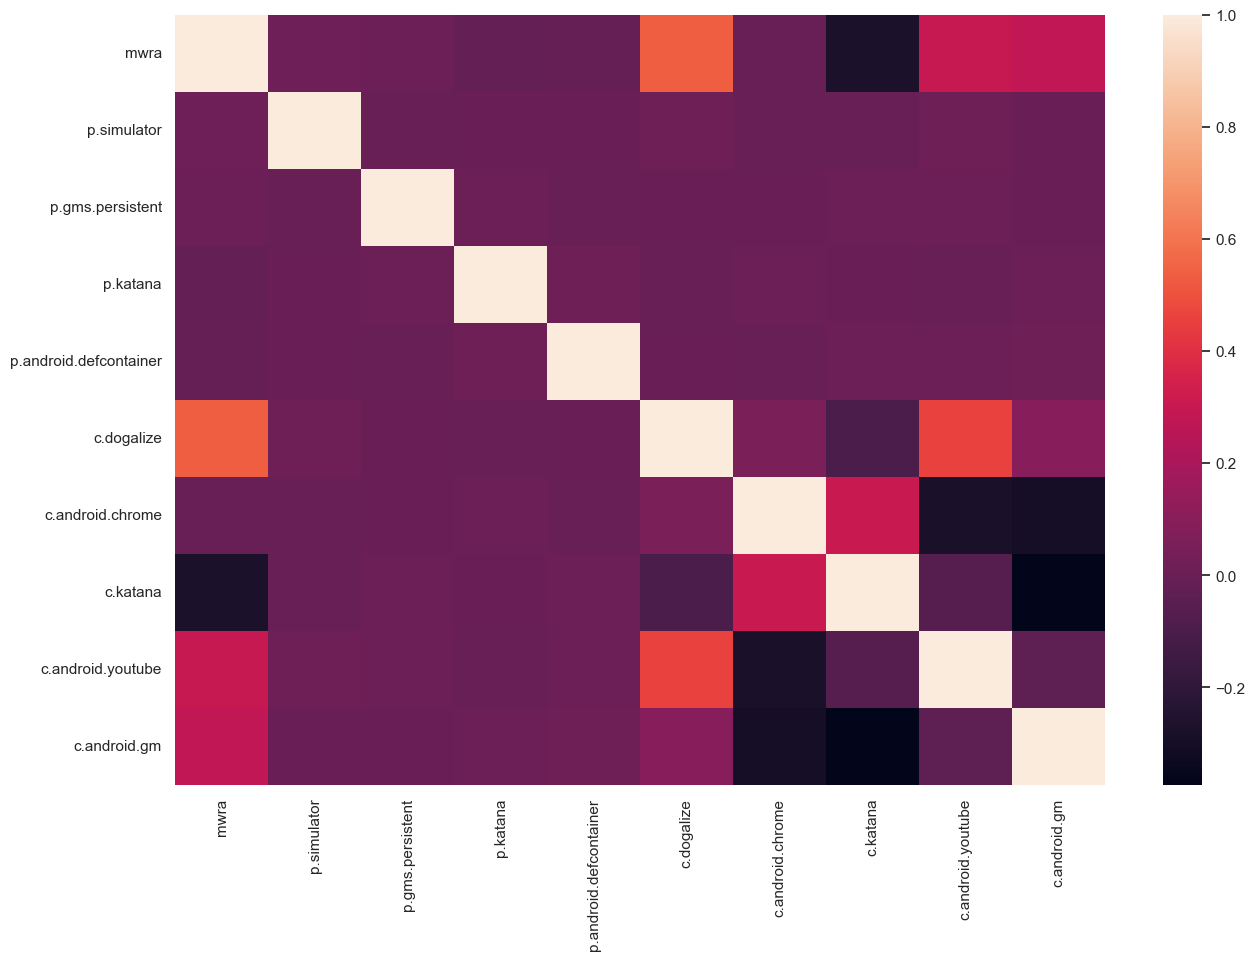

In [128]:
sns.heatmap(data=numeric_norm.select_dtypes("float").corr(method="pearson"))

For those not normally distributed, Spearman's correlation will be aplied:

In [129]:
numeric_notnorm.select_dtypes("float").corr(method="spearman")

,mwra,p.android.packageinstaller,p.android.documentsui,p.android.chrome,p.android.settings,p.android.externalstorage,p.android.gm,p.system,p.browser.provider,p.notifier,...,p.dogalize,p.android.vending,p.google,p.inputmethod.latin,p.android.gms,c.updateassist,c.android.vending,c.UCMobile.intl,c.UCMobile.x86,c.raider
mwra,1.000000,-0.289065,-0.292799,-0.575468,0.012431,0.256173,-0.592250,-0.010733,-0.009282,0.543713,...,-0.007006,-0.009171,0.006325,0.016199,-0.001567,-0.006972,0.002365,-0.008200,0.013308,0.003659
p.android.packageinstaller,-0.289065,1.000000,-0.035093,0.280686,0.106216,-0.159813,0.108279,-0.116895,0.009453,-0.166764,...,-0.001625,0.001784,-0.004832,-0.015750,0.005757,0.002735,0.004286,-0.005626,-0.002697,0.005991
p.android.documentsui,-0.292799,-0.035093,1.000000,0.234488,0.007861,0.067926,0.224235,-0.552486,0.004278,-0.236147,...,0.000461,0.000842,-0.014925,0.001522,0.000273,0.012833,-0.013444,-0.005269,0.003963,-0.009090
p.android.chrome,-0.575468,0.280686,0.234488,1.000000,0.256479,-0.336594,0.411894,-0.032056,0.001819,-0.465006,...,-0.001547,0.000565,0.006404,-0.020261,0.008179,0.019680,0.007588,0.004269,-0.007474,0.006644
p.android.settings,0.012431,0.106216,0.007861,0.256479,1.000000,-0.210552,-0.190749,0.041392,0.002927,-0.050762,...,-0.006503,-0.004990,-0.008957,-0.020218,0.010838,-0.004957,0.008942,-0.015718,0.012626,0.008298
p.android.externalstorage,0.256173,-0.159813,0.067926,-0.336594,-0.210552,1.000000,-0.204244,-0.256062,-0.004272,0.250605,...,-0.014881,-0.003059,0.004920,0.010177,-0.024134,-0.001295,-0.005157,-0.005551,-0.010142,-0.003513
p.android.gm,-0.592250,0.108279,0.224235,0.411894,-0.190749,-0.204244,1.000000,0.062265,0.013659,-0.462998,...,0.003138,0.007259,0.006533,-0.009621,0.001405,0.014401,-0.004519,0.011974,-0.010533,-0.001469
p.system,-0.010733,-0.116895,-0.552486,-0.032056,0.041392,-0.256062,0.062265,1.000000,0.002924,-0.068660,...,0.000954,-0.002560,0.010054,-0.003224,0.020015,-0.005652,0.009695,0.008326,-0.009347,0.007413
p.browser.provider,-0.009282,0.009453,0.004278,0.001819,0.002927,-0.004272,0.013659,0.002924,1.000000,0.005794,...,-0.013844,0.003103,0.001185,0.010249,0.011479,0.007307,-0.009505,0.007870,-0.020465,0.002801
p.notifier,0.543713,-0.166764,-0.236147,-0.465006,-0.050762,0.250605,-0.462998,-0.068660,0.005794,1.000000,...,-0.010105,-0.002193,-0.006247,0.026045,-0.011303,-0.003274,-0.002997,-0.015039,0.011520,0.001415


We can see no correlation has been found there between those not normally distributed.

## 1.1E

There are couple of insights that heatmap may give us:
1) Chrome (browser) service \[perhaps\] often works with documents (documentsui), gmail services (gm), settings and package installer. And doesn't with external storage.
2) External storage \[perhaps\] often utilized by web connections (dogalize, chrome, katana, youtube)
3) Perhaps, dogalize connection doesn't let chrome and gmail proccess to operate normally. Meanwhile, it does work actively with notifications and \[perhaps\] launches youtube connections.

There are also correlations between target attribute and others:
1) Connections with youtube, dogalize and gmail may be potential source of malware activity.
2) Working with external storage may potentially be dangerous.
3) Probably, gmail service and chrome services run their own protections as it can explain strong negative correlation.

# 1.2

As it can be seen in both connections and processes dataframes data is comlete and has no issues (all the values are present and consistent, format is rigorious).

In [130]:
print(conn_df.isnull().sum().sum(), proc_df.isnull().sum().sum())

0 0


So here we will mainly focus on devices and profiles dataframes:

#### Devices

In [131]:
devices_df.isnull().sum()

latitude      0
longitude     0
store_name    0
code          3
location      0
imei          0
dtype: int64

Let's find these three records which have empty values in codes

In [137]:
devices_df[devices_df["code"].isnull()]

,latitude,longitude,store_name,code,location,imei
1591,-21.98333,16.91667,Okahandja,NaN,Africa/Windhoek,3590433799317662493
1598,-21.98333,16.91667,Okahandja,NaN,Africa/Windhoek,359043379931766783
2408,-21.98333,16.91667,Okahandja,NaN,Africa/Windhoek,863033069630348370


As Windhoek is located in Republic of Namibia, let's use it's ISO-2 code to fill in the data: 

In [141]:
devices_df.loc[devices_df["code"].isnull(), "code"] = "NA"
devices_df[devices_df["code"] == "NA"]

,latitude,longitude,store_name,code,location,imei
1591,-21.98333,16.91667,Okahandja,NA,Africa/Windhoek,3590433799317662493
1598,-21.98333,16.91667,Okahandja,NA,Africa/Windhoek,359043379931766783
2408,-21.98333,16.91667,Okahandja,NA,Africa/Windhoek,863033069630348370


Let's also check coordinates, since we know that the valid range of latitude in degrees is -90 and +90 for the southern and northern hemisphere, respectively. Longitude is in the range -180 and +180:

In [145]:
devices_df[(-180 <= devices_df["longitude"]) & (devices_df["longitude"] <= 180) & (-90 <= devices_df["latitude"]) & (devices_df["latitude"] <= 90)].shape

(2963, 6)

All coordinates are valid

#### Profiles

Let's firstly estimate the number of empty values in each column:

In [147]:
profiles_df.isnull().sum()

registration           0
username               0
residence           1649
company                0
name                   0
birthdate           1142
ssn                    0
mail                   0
user_id                0
current_location     127
imei                   0
job                 1776
dtype: int64

In [148]:
profiles_df.shape

(2537, 12)

In [151]:
print("Residence empty (%):", 1649 / 2527 * 100)
print("birthdate empty (%):", 1142 / 2527 * 100)
print("current_location empty (%):", 127 / 2527 * 100)
print("job empty (%):", 1776 / 2527 * 100)

Residence empty (%): 65.25524337158686
birthdate empty (%): 45.19192718638702
current_location empty (%): 5.0257222002374355
job empty (%): 70.2809655718243


It makes sense to drop residence and job columns as this value can be hardly substited and actually mostly are not presented in dataset.

In [160]:
profiles_cleandf = profiles_df.drop(["residence", "job"], axis=1)
profiles_cleandf

,registration,username,company,name,birthdate,ssn,mail,user_id,current_location,imei
0,2019/09/09,jasonmiller,Leonard Ltd,Christopher Ramsey,NaN,456-43-0025,barbaraharper@yahoo.com,569,"(Decimal('-35.4866605'), Decimal('-126.966117'))",8630330696303482345
1,26 Oct 2022,bsmith,"Lang, Garza and Martin",Matthew Ross,NaN,401-60-5272,lisakhan@yahoo.com,1287,"(Decimal('-71.2577755'), Decimal('-24.088612'))",863033069630348305
2,2023/11/12,jeanette92,Allison-Thomas,Bobby Garcia,NaN,756-46-0240,diana16@yahoo.com,1454,"(Decimal('15.5502415'), Decimal('74.236302'))",863033069630348529
3,2022-03-01,mariagonzalez,Levine-Smith,Nicole Fitzgerald,NaN,110-17-7224,sullivananthony@gmail.com,2508,"(Decimal('76.283353'), Decimal('-1.336879'))",3590433799317661347
4,2018/01/04,susan66,Gross Ltd,Jeremy Ford,1925-08-22,209-60-6164,toddlewis@hotmail.com,1236,"(Decimal('-1.2822215'), Decimal('25.470396'))",863033069630348057
...,...,...,...,...,...,...,...,...,...,...
2532,2018/12/21,randall20,"Weaver, Logan and Chan",Andrew Mitchell,NaN,518-35-4627,brandonho@yahoo.com,1787,NaN,3590433799317662329
2533,"10/16/2018, 00:00:00",downsdarin,"Gill, Downs and Esparza",Michael Dodson,1965-01-15,382-24-1772,antoniomay@yahoo.com,1422,"(Decimal('45.428582'), Decimal('-99.719827'))",359043379931766643
2534,2019-12-19,danieldeleon,Roth-Bell,Jerry Peterson,1924-04-08,677-27-7010,simpsontracy@gmail.com,2429,"(Decimal('-65.724331'), Decimal('71.251540'))",863033069630348537
2535,"10/14/2021, 00:00:00",olivia11,Andrade-Rivera,Valerie Sanchez,2007-06-12,138-75-9242,gdavis@hotmail.com,19,"(Decimal('37.6123115'), Decimal('104.117267'))",359043379931766858


Further work regarding missing values will be done in 1.2B. Now let's see which columns have an inconsistent or inappropriate format:

In [161]:
profiles_cleandf.head()

,registration,username,company,name,birthdate,ssn,mail,user_id,current_location,imei
0,2019/09/09,jasonmiller,Leonard Ltd,Christopher Ramsey,NaN,456-43-0025,barbaraharper@yahoo.com,569,"(Decimal('-35.4866605'), Decimal('-126.966117'))",8630330696303482345
1,26 Oct 2022,bsmith,"Lang, Garza and Martin",Matthew Ross,NaN,401-60-5272,lisakhan@yahoo.com,1287,"(Decimal('-71.2577755'), Decimal('-24.088612'))",863033069630348305
2,2023/11/12,jeanette92,Allison-Thomas,Bobby Garcia,NaN,756-46-0240,diana16@yahoo.com,1454,"(Decimal('15.5502415'), Decimal('74.236302'))",863033069630348529
3,2022-03-01,mariagonzalez,Levine-Smith,Nicole Fitzgerald,NaN,110-17-7224,sullivananthony@gmail.com,2508,"(Decimal('76.283353'), Decimal('-1.336879'))",3590433799317661347
4,2018/01/04,susan66,Gross Ltd,Jeremy Ford,1925-08-22,209-60-6164,toddlewis@hotmail.com,1236,"(Decimal('-1.2822215'), Decimal('25.470396'))",863033069630348057


It's obvious that registration has inconsistent format and current_location provides inconviniet format for futher processing. Let's firstly deal with registration.

In [156]:
from dateutil.parser import parse # To parse unknown datetime format

In [158]:
parse(profiles_cleandf.iloc[0, 0], fuzzy=True)

'09-09-2019'

That's how this util works, now let's create new column which will hold datetime values in a single unified format yyyy-dd-mm:

In [164]:
profiles_cleandf.insert(0, "regdate", profiles_cleandf["registration"].apply(parse, fuzzy=True))
profiles_cleandf.drop("registration", axis=1)
profiles_cleandf

,regdate,registration,username,company,name,birthdate,ssn,mail,user_id,current_location,imei
0,2019-09-09,2019/09/09,jasonmiller,Leonard Ltd,Christopher Ramsey,NaN,456-43-0025,barbaraharper@yahoo.com,569,"(Decimal('-35.4866605'), Decimal('-126.966117'))",8630330696303482345
1,2022-10-26,26 Oct 2022,bsmith,"Lang, Garza and Martin",Matthew Ross,NaN,401-60-5272,lisakhan@yahoo.com,1287,"(Decimal('-71.2577755'), Decimal('-24.088612'))",863033069630348305
2,2023-11-12,2023/11/12,jeanette92,Allison-Thomas,Bobby Garcia,NaN,756-46-0240,diana16@yahoo.com,1454,"(Decimal('15.5502415'), Decimal('74.236302'))",863033069630348529
3,2022-03-01,2022-03-01,mariagonzalez,Levine-Smith,Nicole Fitzgerald,NaN,110-17-7224,sullivananthony@gmail.com,2508,"(Decimal('76.283353'), Decimal('-1.336879'))",3590433799317661347
4,2018-01-04,2018/01/04,susan66,Gross Ltd,Jeremy Ford,1925-08-22,209-60-6164,toddlewis@hotmail.com,1236,"(Decimal('-1.2822215'), Decimal('25.470396'))",863033069630348057
...,...,...,...,...,...,...,...,...,...,...,...
2532,2018-12-21,2018/12/21,randall20,"Weaver, Logan and Chan",Andrew Mitchell,NaN,518-35-4627,brandonho@yahoo.com,1787,NaN,3590433799317662329
2533,2018-10-16,"10/16/2018, 00:00:00",downsdarin,"Gill, Downs and Esparza",Michael Dodson,1965-01-15,382-24-1772,antoniomay@yahoo.com,1422,"(Decimal('45.428582'), Decimal('-99.719827'))",359043379931766643
2534,2019-12-19,2019-12-19,danieldeleon,Roth-Bell,Jerry Peterson,1924-04-08,677-27-7010,simpsontracy@gmail.com,2429,"(Decimal('-65.724331'), Decimal('71.251540'))",863033069630348537
2535,2021-10-14,"10/14/2021, 00:00:00",olivia11,Andrade-Rivera,Valerie Sanchez,2007-06-12,138-75-9242,gdavis@hotmail.com,19,"(Decimal('37.6123115'), Decimal('104.117267'))",359043379931766858
